## **CNN para classificação multiclasse de imagens**
## - Visualização dos filtros e dos *featuremaps*
**Dataset MNIST (Modified National Institute of Standards and Technology)**
- É considerado o dataset “hello world” de *computer vision*.
- Dataset de imagens de dígitos escritos manualmente
- Inputs: imagens de 28x28 pixeis
- Output: classe a representar o dígito (10 classes, dígitos 0-9)
- 70k imagens das quais 60k são para treino e 10k para teste
- 2 atributos: o id da imagem e o respetivo label   

Vamos utilizar uma rede neuronal para classificação do dígito em cada imagem de 28x28.

## imports

In [102]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from PIL import Image

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
import torch.nn as nn
from torch.nn import BatchNorm2d
from torch.nn import Dropout2d
from torch.nn import Sequential
from torch.nn import Linear
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Adam
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
 
import torchvision.transforms as transforms
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torchinfo import summary

from livelossplot import PlotLosses

import pandas as pd

np.random.seed(0) 
torch.manual_seed(0)
import random
random.seed(0)

In [103]:
PATH = './'
PATH_TRAIN = './mnist_train.csv'
PATH_TEST = './mnist_test.csv'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 32

In [104]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data,(list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
         for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

device = get_default_device()
print(device)

cpu


## 1. Preparar os Dados

In [105]:
train_transform = Compose(
        [ToTensor(), 
         Normalize(mean=(0.1307,), std=(0.3081,))
        ])
test_transform = Compose(
        [ToTensor(), 
         Normalize(mean=(0.1307,), std=(0.3081,))
        ])

In [106]:
class CSVDataset(Dataset):

    def __init__(self, path, transform=None):
        self.transform = transform

        df_set = pd.read_csv(path, header=0)

        self.x = df_set.values[:, 1:]
        self.y = df_set.values[:, 0]

        self.x = self.x.astype('float32')
        self.y = self.y.astype('long')

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        label = self.y[idx]
        image = self.x[idx]       
        if self.transform is not None:
            image = self.transform(image)
        return image, label
        
    def get_TensorDataset(self):
        x = self.x.reshape(len(self.x), 1, 28, 28)
        xmax, xmin = x.max(), x.min()
        x = (x-xmin)/(xmax-xmin)
        x  = torch.from_numpy(np.array(x)).float()
        y  = torch.from_numpy(np.array(self.y)).type(torch.LongTensor)
        cases = torch.utils.data.TensorDataset(x,y)
        return cases 

def prepare_data_loaders(path_train, path_test):
    dataset_train = CSVDataset(path_train,transform=train_transform)
    dataset_test = CSVDataset(path_test,transform=test_transform)
    train = dataset_train.get_TensorDataset()
    train_size = int(0.8 * len(train))
    val_size = len(train) - train_size
    train, validation = random_split(train, [train_size, val_size], generator=torch.Generator().manual_seed(42))
    test = dataset_test.get_TensorDataset()
    
    train_dl = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
    val_dl = DataLoader(validation, batch_size=BATCH_SIZE, shuffle=True)
    test_dl = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)
    train_dl_all = DataLoader(train, batch_size=len(train), shuffle=False)
    val_dl_all = DataLoader(validation, batch_size=len(validation), shuffle=True)
    test_dl_all = DataLoader(test, batch_size=len(test), shuffle=False)
    return train_dl, val_dl, test_dl, train_dl_all, val_dl_all, test_dl_all

train_dl, val_dl, test_dl, train_dl_all, val_dl_all, test_dl_all = prepare_data_loaders(PATH_TRAIN, PATH_TEST)

## 1.1 Visualizar os Dados

In [107]:
def output_label(label,mapping='label'):
    if mapping == 'ext':
        output_mapping = { 0:"zero", 1:"um", 2:"dois", 3:"tres", 4:"quatro", 5:"cinco", 6:"seis", 7:"sete", 8:"oito", 9:"nove" }
    elif mapping == 'ext2':
        output_mapping = { "0":"zero", "1":"um", "2":"dois", "3":"tres", "4":"quatro", "5":"cinco", "6":"seis", "7":"sete", "8":"oito", "9":"nove" }
    else:
        output_mapping = { 0: "0", 1: "1", 2: "2", 3: "3", 4: "4", 5: "5", 6: "6", 7: "7", 8: "8", 9: "9"}
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

torch.Size([32, 1, 28, 28])


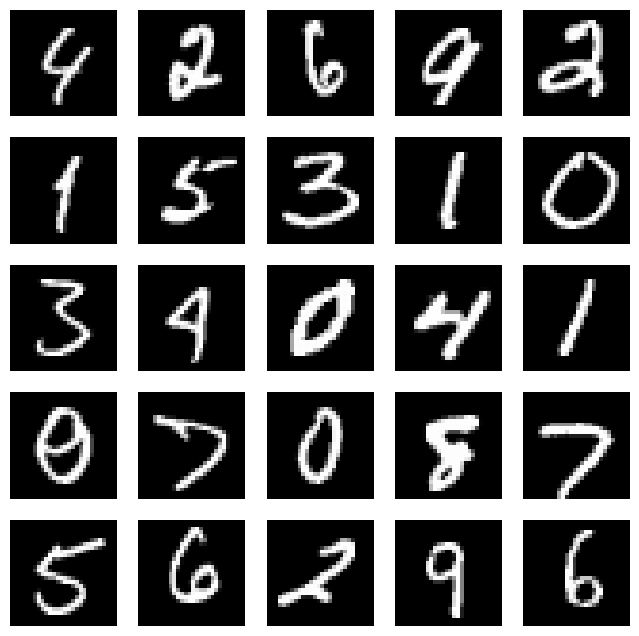

In [108]:
def visualize_mnist_images(dl):
    i, (inputs, targets) = next(enumerate(dl))
    print(inputs.shape)
    plt.figure(figsize=(8,8))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.axis('off')
        plt.grid(False)
        plt.imshow(inputs[i][0], cmap='gray')
    plt.show()
visualize_mnist_images(train_dl)

## 2. Definir o Modelo

In [109]:
class CNNModel_1(Module):
    def __init__(self):
        super(CNNModel_1, self).__init__()
        self.layer1 = Sequential(Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3)),
                                 ReLU(),
                                 MaxPool2d(kernel_size=(2,2), stride=(2,2))           
                                )
        self.layer2 = Sequential(Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3)),
                                 ReLU(),
                                 MaxPool2d(kernel_size=(2,2), stride=(2,2))           
                                )
        self.fc1 = Linear(in_features=5*5*32, out_features=100)
        kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        self.fc2 = Linear(in_features=100, out_features=10)
        xavier_uniform_(self.fc2.weight)
        self.act2 = Softmax(dim=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(-1, 4*4*50)
        out = self.fc1(out)
        out = self.act1(out)
        out = self.fc2(out) 
        out = self.act2(out)
        return out

model = CNNModel_1()
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0)) 

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_1                               [32, 10]                  --
├─Sequential: 1-1                        [32, 32, 13, 13]          --
│    └─Conv2d: 2-1                       [32, 32, 26, 26]          320
│    └─ReLU: 2-2                         [32, 32, 26, 26]          --
│    └─MaxPool2d: 2-3                    [32, 32, 13, 13]          --
├─Sequential: 1-2                        [32, 32, 5, 5]            --
│    └─Conv2d: 2-4                       [32, 32, 11, 11]          9,248
│    └─ReLU: 2-5                         [32, 32, 11, 11]          --
│    └─MaxPool2d: 2-6                    [32, 32, 5, 5]            --
├─Linear: 1-3                            [32, 100]                 80,100
├─ReLU: 1-4                              [32, 100]                 --
├─Linear: 1-5                            [32, 10]                  1,010
├─Softmax: 1-6                           [32, 10]                  --
Tota

In [110]:
class CNNModel_2(Module):
    def __init__(self):
        super(CNNModel_2, self).__init__()
        self.layer1 = Sequential(Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=0),
                                 ReLU(),
                                 MaxPool2d(kernel_size=2)
                                )
        self.layer2 = Sequential(Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0),
                                 ReLU(),
                                 MaxPool2d(kernel_size=2)
                                )       
        self.fc1 = Linear(32 * 5 * 5, 10)  
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) 
        out = self.fc1(out) 
        return out
    
model = CNNModel_2()
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_2                               [32, 10]                  --
├─Sequential: 1-1                        [32, 16, 13, 13]          --
│    └─Conv2d: 2-1                       [32, 16, 26, 26]          160
│    └─ReLU: 2-2                         [32, 16, 26, 26]          --
│    └─MaxPool2d: 2-3                    [32, 16, 13, 13]          --
├─Sequential: 1-2                        [32, 32, 5, 5]            --
│    └─Conv2d: 2-4                       [32, 32, 11, 11]          4,640
│    └─ReLU: 2-5                         [32, 32, 11, 11]          --
│    └─MaxPool2d: 2-6                    [32, 32, 5, 5]            --
├─Linear: 1-3                            [32, 10]                  8,010
Total params: 12,810
Trainable params: 12,810
Non-trainable params: 0
Total mult-adds (M): 21.68
Input size (MB): 0.10
Forward/backward pass size (MB): 3.76
Params size (MB): 0.05
Estimated Total Size (MB): 3.91


In [111]:
class CNNModel_3(Module):
    def __init__(self):
        super(CNNModel_3, self).__init__()
        self.layer1 = nn.Sequential(Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
                                    BatchNorm2d(32),
                                    ReLU(),
                                    MaxPool2d(kernel_size=2, stride=2)
                                    )
        self.layer2 = nn.Sequential(Conv2d(in_channels=32, out_channels=64, kernel_size=3),
                                    BatchNorm2d(64),
                                    ReLU(),
                                    MaxPool2d(2)
                                    )
        self.fc1 = Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = Linear(in_features=600, out_features=120)
        self.fc3 = Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out
    
model = CNNModel_3()
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))


Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_3                               [32, 10]                  --
├─Sequential: 1-1                        [32, 32, 14, 14]          --
│    └─Conv2d: 2-1                       [32, 32, 28, 28]          320
│    └─BatchNorm2d: 2-2                  [32, 32, 28, 28]          64
│    └─ReLU: 2-3                         [32, 32, 28, 28]          --
│    └─MaxPool2d: 2-4                    [32, 32, 14, 14]          --
├─Sequential: 1-2                        [32, 64, 6, 6]            --
│    └─Conv2d: 2-5                       [32, 64, 12, 12]          18,496
│    └─BatchNorm2d: 2-6                  [32, 64, 12, 12]          128
│    └─ReLU: 2-7                         [32, 64, 12, 12]          --
│    └─MaxPool2d: 2-8                    [32, 64, 6, 6]            --
├─Linear: 1-3                            [32, 600]                 1,383,000
├─Dropout2d: 1-4                         [32, 600]                 --
├─

/Users/goncalobraga/miniconda3/envs/DAA/lib/python3.10/site-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [112]:
class CNNModel_4(Module):
    def __init__(self):
        super(CNNModel_4, self).__init__()
        self.layer1 = Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=0),
                                    BatchNorm2d(32),
                                    ReLU(),
                                    MaxPool2d(2),
                                    Dropout2d(0.2)
                                    )
        self.fc1 = Linear(in_features=32*12*12, out_features=128)
        self.fc2 = Linear(in_features=128, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    
model = CNNModel_4()
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_4                               [32, 10]                  --
├─Sequential: 1-1                        [32, 32, 12, 12]          --
│    └─Conv2d: 2-1                       [32, 32, 24, 24]          832
│    └─BatchNorm2d: 2-2                  [32, 32, 24, 24]          64
│    └─ReLU: 2-3                         [32, 32, 24, 24]          --
│    └─MaxPool2d: 2-4                    [32, 32, 12, 12]          --
│    └─Dropout2d: 2-5                    [32, 32, 12, 12]          --
├─Linear: 1-2                            [32, 128]                 589,952
├─Linear: 1-3                            [32, 10]                  1,290
Total params: 592,138
Trainable params: 592,138
Non-trainable params: 0
Total mult-adds (M): 34.26
Input size (MB): 0.10
Forward/backward pass size (MB): 9.47
Params size (MB): 2.37
Estimated Total Size (MB): 11.94


## 3. Treinar o Modelo

In [113]:
def train_model(h5_file, train_dl, val_dl, model, criterion, optimizer):
    liveloss = PlotLosses()
    for epoch in range(EPOCHS):
        logs = {}
        model.train() 
        running_loss  = 0.0
        running_corrects  = 0.0
        for inputs, labels in train_dl: 
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.detach() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(train_dl.dataset)
        epoch_acc = running_corrects.float() / len(train_dl.dataset)
        logs['loss'] = epoch_loss.item()
        logs['accuracy'] = epoch_acc.item()
            
        model.eval()
        running_loss  = 0.0
        running_corrects  = 0.0
        for inputs, labels in val_dl: 
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.detach() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(val_dl.dataset)
        epoch_acc = running_corrects.float() / len(val_dl.dataset)
        logs['val_loss'] = epoch_loss.item()
        logs['val_accuracy'] = epoch_acc.item()
        liveloss.update(logs)
        liveloss.send()
    torch.save(model,h5_file)

In [114]:
######### CNNModel_1 ################
model = CNNModel_1()
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_1                               [32, 10]                  --
├─Sequential: 1-1                        [32, 32, 13, 13]          --
│    └─Conv2d: 2-1                       [32, 32, 26, 26]          320
│    └─ReLU: 2-2                         [32, 32, 26, 26]          --
│    └─MaxPool2d: 2-3                    [32, 32, 13, 13]          --
├─Sequential: 1-2                        [32, 32, 5, 5]            --
│    └─Conv2d: 2-4                       [32, 32, 11, 11]          9,248
│    └─ReLU: 2-5                         [32, 32, 11, 11]          --
│    └─MaxPool2d: 2-6                    [32, 32, 5, 5]            --
├─Linear: 1-3                            [32, 100]                 80,100
├─ReLU: 1-4                              [32, 100]                 --
├─Linear: 1-5                            [32, 10]                  1,010
├─Softmax: 1-6                           [32, 10]                  --
Tota

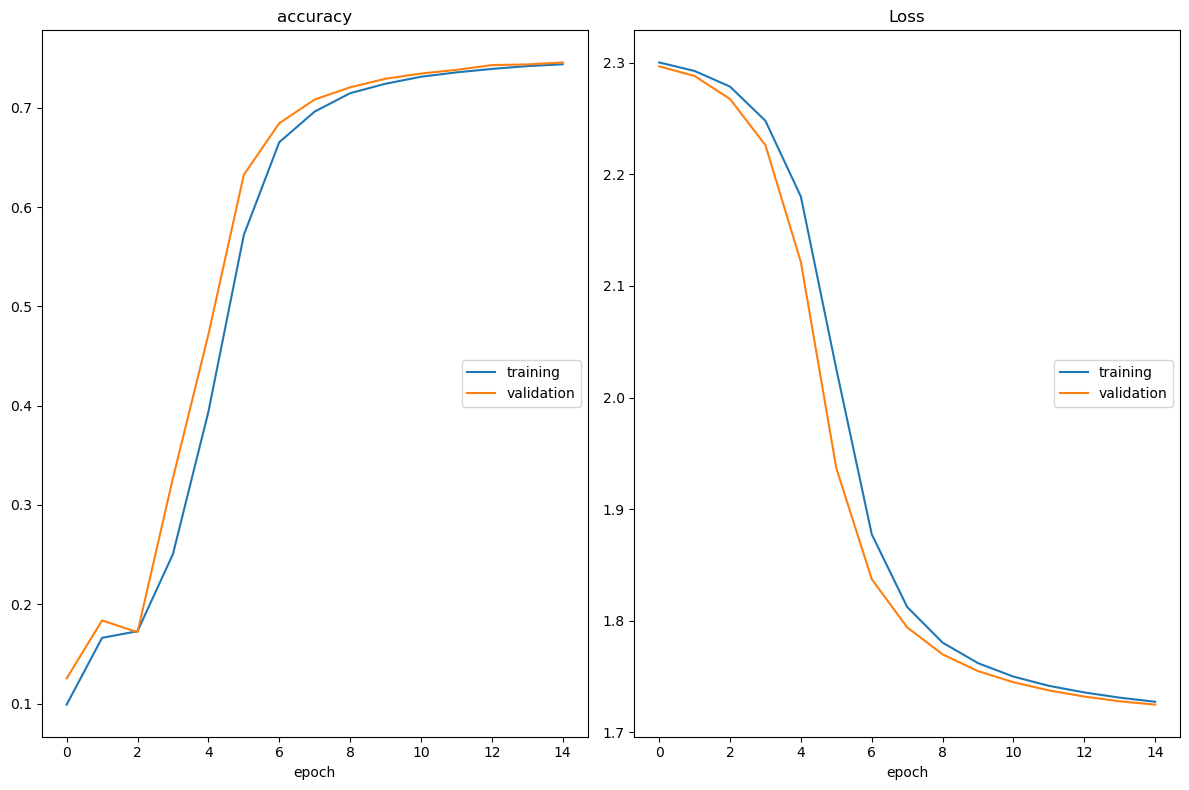

accuracy
	training         	 (min:    0.099, max:    0.744, cur:    0.744)
	validation       	 (min:    0.125, max:    0.746, cur:    0.746)
Loss
	training         	 (min:    1.727, max:    2.300, cur:    1.727)
	validation       	 (min:    1.725, max:    2.297, cur:    1.725)
Tempo gasto: 881.541508209004 segundos


In [115]:
EPOCHS = 15
LEARNING_RATE = 0.001
criterion = CrossEntropyLoss() 
optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 
starttime = time.perf_counter()
train_model('CNNModel_1.pth', train_dl, val_dl, model, criterion, optimizer)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

In [116]:
######### CNNModel_2 ################
model = CNNModel_2()
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_2                               [32, 10]                  --
├─Sequential: 1-1                        [32, 16, 13, 13]          --
│    └─Conv2d: 2-1                       [32, 16, 26, 26]          160
│    └─ReLU: 2-2                         [32, 16, 26, 26]          --
│    └─MaxPool2d: 2-3                    [32, 16, 13, 13]          --
├─Sequential: 1-2                        [32, 32, 5, 5]            --
│    └─Conv2d: 2-4                       [32, 32, 11, 11]          4,640
│    └─ReLU: 2-5                         [32, 32, 11, 11]          --
│    └─MaxPool2d: 2-6                    [32, 32, 5, 5]            --
├─Linear: 1-3                            [32, 10]                  8,010
Total params: 12,810
Trainable params: 12,810
Non-trainable params: 0
Total mult-adds (M): 21.68
Input size (MB): 0.10
Forward/backward pass size (MB): 3.76
Params size (MB): 0.05
Estimated Total Size (MB): 3.91


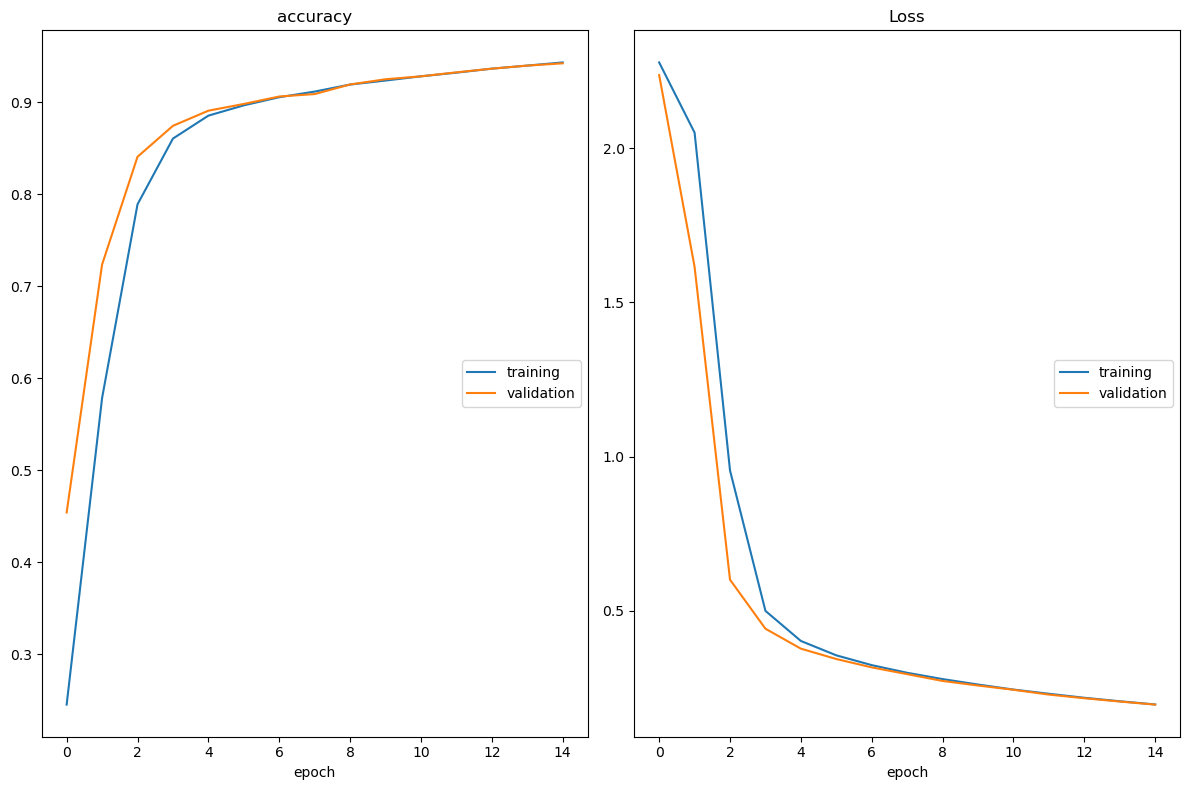

accuracy
	training         	 (min:    0.245, max:    0.943, cur:    0.943)
	validation       	 (min:    0.454, max:    0.942, cur:    0.942)
Loss
	training         	 (min:    0.196, max:    2.277, cur:    0.196)
	validation       	 (min:    0.196, max:    2.237, cur:    0.196)
Tempo gasto: 506.12740104099794 segundos


In [117]:
EPOCHS = 15
LEARNING_RATE = 0.001
criterion = CrossEntropyLoss() 
optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 
starttime = time.perf_counter()
train_model('CNNModel_2.pth', train_dl, val_dl, model, criterion, optimizer)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

In [118]:
######### CNNModel_3 ################
model = CNNModel_3()
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_3                               [32, 10]                  --
├─Sequential: 1-1                        [32, 32, 14, 14]          --
│    └─Conv2d: 2-1                       [32, 32, 28, 28]          320
│    └─BatchNorm2d: 2-2                  [32, 32, 28, 28]          64
│    └─ReLU: 2-3                         [32, 32, 28, 28]          --
│    └─MaxPool2d: 2-4                    [32, 32, 14, 14]          --
├─Sequential: 1-2                        [32, 64, 6, 6]            --
│    └─Conv2d: 2-5                       [32, 64, 12, 12]          18,496
│    └─BatchNorm2d: 2-6                  [32, 64, 12, 12]          128
│    └─ReLU: 2-7                         [32, 64, 12, 12]          --
│    └─MaxPool2d: 2-8                    [32, 64, 6, 6]            --
├─Linear: 1-3                            [32, 600]                 1,383,000
├─Dropout2d: 1-4                         [32, 600]                 --
├─

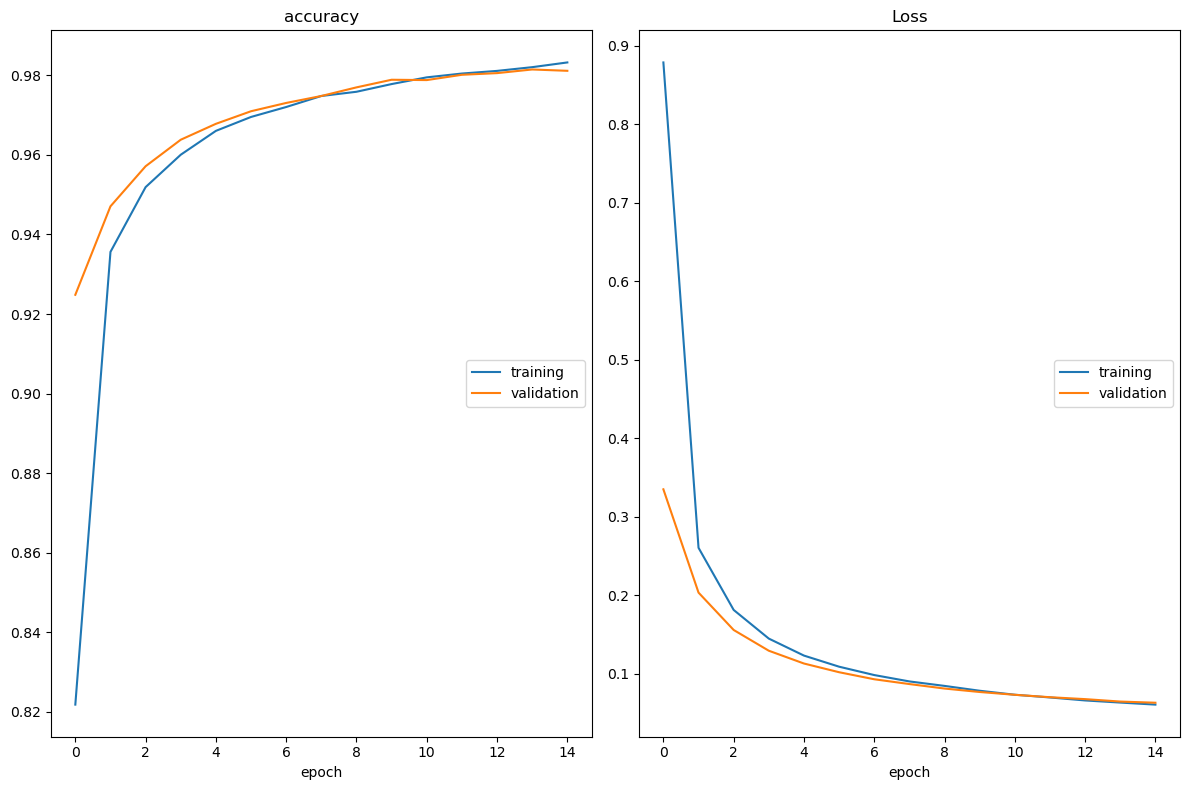

accuracy
	training         	 (min:    0.822, max:    0.983, cur:    0.983)
	validation       	 (min:    0.925, max:    0.982, cur:    0.981)
Loss
	training         	 (min:    0.061, max:    0.879, cur:    0.061)
	validation       	 (min:    0.063, max:    0.335, cur:    0.063)
Tempo gasto: 1183.3240325829975 segundos


In [119]:
EPOCHS = 15
LEARNING_RATE = 0.001
criterion = CrossEntropyLoss() 
optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 
starttime = time.perf_counter()
train_model('CNNModel_3.pth', train_dl, val_dl, model, criterion, optimizer)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

In [120]:
######### CNNModel_4 ################
model = CNNModel_4()
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_4                               [32, 10]                  --
├─Sequential: 1-1                        [32, 32, 12, 12]          --
│    └─Conv2d: 2-1                       [32, 32, 24, 24]          832
│    └─BatchNorm2d: 2-2                  [32, 32, 24, 24]          64
│    └─ReLU: 2-3                         [32, 32, 24, 24]          --
│    └─MaxPool2d: 2-4                    [32, 32, 12, 12]          --
│    └─Dropout2d: 2-5                    [32, 32, 12, 12]          --
├─Linear: 1-2                            [32, 128]                 589,952
├─Linear: 1-3                            [32, 10]                  1,290
Total params: 592,138
Trainable params: 592,138
Non-trainable params: 0
Total mult-adds (M): 34.26
Input size (MB): 0.10
Forward/backward pass size (MB): 9.47
Params size (MB): 2.37
Estimated Total Size (MB): 11.94


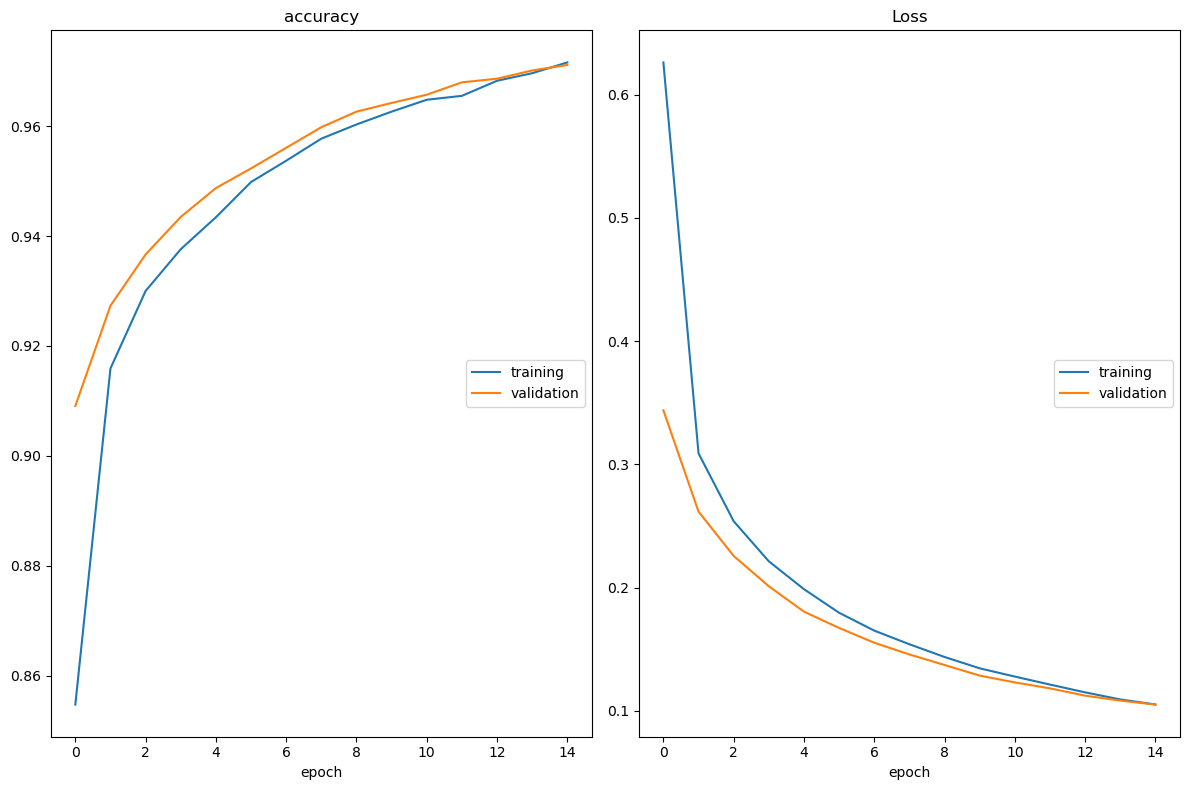

accuracy
	training         	 (min:    0.855, max:    0.972, cur:    0.972)
	validation       	 (min:    0.909, max:    0.971, cur:    0.971)
Loss
	training         	 (min:    0.105, max:    0.626, cur:    0.105)
	validation       	 (min:    0.105, max:    0.344, cur:    0.105)
Tempo gasto: 505.9949234579981 segundos


In [121]:
EPOCHS = 15
LEARNING_RATE = 0.001
criterion = CrossEntropyLoss() 
optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 
starttime = time.perf_counter()
train_model('CNNModel_4.pth', train_dl, val_dl, model, criterion, optimizer)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

## 4. Avaliar o Modelo

real:[2] previsão:[2]
real:[1] previsão:[1]
real:[0] previsão:[0]
real:[4] previsão:[4]
real:[1] previsão:[1]
real:[4] previsão:[4]
real:[9] previsão:[4]
real:[5] previsão:[2]
real:[9] previsão:[7]
real:[0] previsão:[0]
real:[6] previsão:[6]
real:[9] previsão:[4]
real:[0] previsão:[0]
real:[1] previsão:[1]
real:[5] previsão:[5]
real:[9] previsão:[4]
real:[7] previsão:[7]
real:[3] previsão:[3]
real:[4] previsão:[4]
real:[9] previsão:[7]
Accuracy: 0.750

acertou:7503 falhou:2496
Accuracy: 0.750

acertou:7503 falhou:2496
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       980
           1       0.92      0.97      0.94      1135
           2       0.91      0.89      0.90      1032
           3       0.70      0.93      0.80      1010
           4       0.61      0.96      0.74       982
           5       0.61      0.87      0.71       892
           6       0.87      0.95      0.91       958
           7       0.63      0.93      0.75

/Users/goncalobraga/miniconda3/envs/DAA/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/goncalobraga/miniconda3/envs/DAA/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/goncalobraga/miniconda3/envs/DAA/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

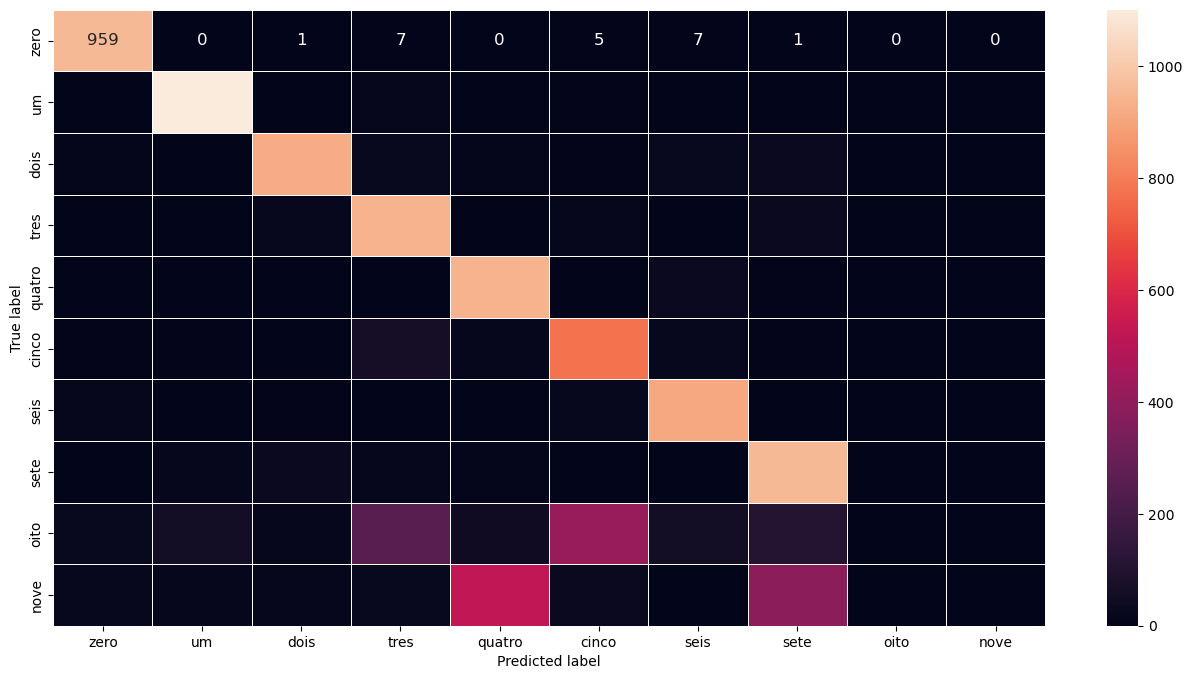

In [122]:
import seaborn as sns
def evaluate_model(test_dl, model):
    predictions = list()
    actual_values = list()
    for inputs, labels in test_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)
        yprev = model(inputs)
        yprev = yprev.detach().cpu().numpy()
        actual = labels.cpu().numpy()
        yprev = np.argmax(yprev, axis=1)
        actual = actual.reshape((len(actual), 1))
        yprev = yprev.reshape((len(yprev), 1))
        predictions.append(yprev)
        actual_values.append(actual)
        break
    predictions, actual_values = np.vstack(predictions), np.vstack(actual_values)
    return actual_values, predictions

def display_predictions(actual_values, predictions ):
    acertou=0
    falhou = 0
    primeiros=0
    for r,p in zip(actual_values, predictions):
        if primeiros <20:
            print(f'real:{r} previsão:{p}') 
            primeiros +=1
        if r==p: acertou+=1  
        else: falhou+=1

    corrects = np.sum(predictions == actual_values)
    acc = corrects / len(test_dl.dataset)
    acc = accuracy_score(actual_values, predictions)
    print(f'Accuracy: {acc:0.3f}\n')
    print(f'acertou:{acertou} falhou:{falhou}')

    acc = accuracy_score(actual_values, predictions)
    print(f'Accuracy: {acc:0.3f}\n')
    print(f'acertou:{acertou} falhou:{falhou}')

def display_confusion_matrix(cm,list_classes):
    plt.figure(figsize = (16,8))
    sns.heatmap(cm,annot=True,xticklabels=list_classes,yticklabels=list_classes, annot_kws={"size": 12}, fmt='g', linewidths=.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show() 
    
model = torch.load('CNNModel_1.pth')
actual_values, predictions = evaluate_model(test_dl_all, model)

display_predictions(actual_values, predictions )
print(classification_report(actual_values, predictions))
cr =classification_report(actual_values, predictions, output_dict=True)
list_classes=[output_label(n,'ext2') for n in list(cr.keys())[0:10] ] 
cm = confusion_matrix(actual_values, predictions)

print (cm)
display_confusion_matrix(cm,list_classes)

## 5. Usar o Modelo

torch.Size([1, 1, 28, 28])
torch.float32


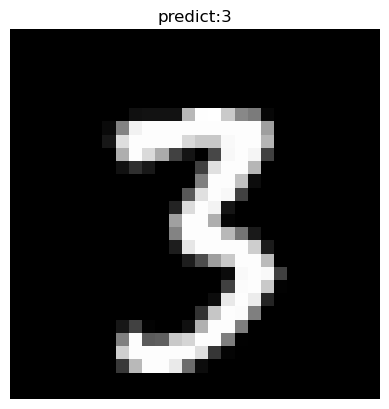

In [123]:
def img_show(img, legenda): 
    img=img.cpu()
    plt.axis('off')
    plt.title(legenda)
    plt.grid(False)
    plt.imshow(img[0,0], cmap=plt.get_cmap('gray'))
    plt.show()

def make_prediction(model, img): 
    img = img.reshape(1, 1, 28, 28) 
    print(img.shape)
    print(img.dtype) 
    img = img.to(device) 
    prediction = model(img).cpu().detach().numpy()[0].argmax()
    legenda=f"predict:{prediction}"
    img_show(img,legenda)

model = torch.load('CNNModel_1.pth')
model.eval()
imagens, label = next(iter(test_dl))
make_prediction(model,imagens[3])

torch.Size([1, 1, 28, 28])
torch.float32


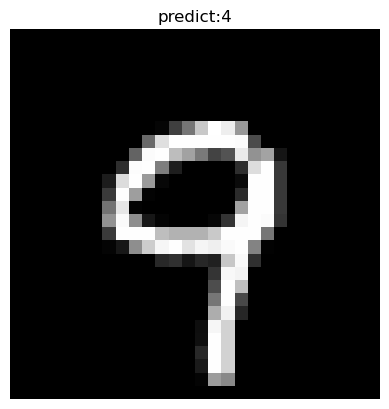

pred: None
None


In [124]:
def show_batch_images(model,dataloader,num_image):
    imagens, label = next(iter(test_dl))
    pred = make_prediction(model,imagens[3]) 
    print("pred:",pred)
    return imagens, pred

...
model.eval()
images, pred = show_batch_images(model,test_dl,1)
print(pred)

In [125]:
...

Ellipsis

In [126]:
def plot_filters_single_channel_big(t):
    nrows = t.shape[0]*t.shape[2]
    ncols = t.shape[1]*t.shape[3]
    npimg = np.array(t.numpy(), np.float32)
    npimg = npimg.transpose((0, 2, 1, 3))
    npimg = npimg.ravel().reshape(nrows, ncols)
    npimg = npimg.T
    fig, ax = plt.subplots(figsize=(ncols/10, nrows/200))    
    imgplot = sns.heatmap(npimg, xticklabels=False, yticklabels=False, cmap='gray', ax=ax, cbar=False)

def plot_filters_single_channel(t):
    ...
    ncols = 12
    nrows = 1 + nplots//ncols
    npimg = np.array(t.numpy(), np.float32) 
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    for i in range(t.shape[0]): 
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
    plt.tight_layout()
    plt.show()

def plot_filters_multi_channel(t):
    num_kernels = t.shape[0]     
    num_cols = 12 
    num_rows = num_kernels
    fig = plt.figure(figsize=(num_cols,num_rows)) 
    for i in range(t.shape[0]): 
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        npimg = np.array(t[i].numpy(), np.float32) 
        npimg = (npimg - np.mean(npimg)) / np.std(npimg) 
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
    plt.savefig('kernels.png', dpi=100)    
    plt.tight_layout()
    ...

def plot_weights(layer, single_channel = True, collated = False):
    if isinstance(layer, nn.Conv2d):
        weight_tensor = layer.weight.data 
        if single_channel:
            if collated:
                plot_filters_single_channel_big(weight_tensor.cpu())
            else:
                plot_filters_single_channel(weight_tensor.cpu() )
        else:
            if weight_tensor.shape[1] == 3:
                plot_filters_multi_channel(weight_tensor.cpu())
            else:
                print("Can only plot weights with three channels with single channel = False")
    else:
        print("Can only visualize layers which are convolutional")
        
...

Ellipsis

In [127]:
...

Ellipsis

torch.Size([1, 1, 28, 28])
torch.float32


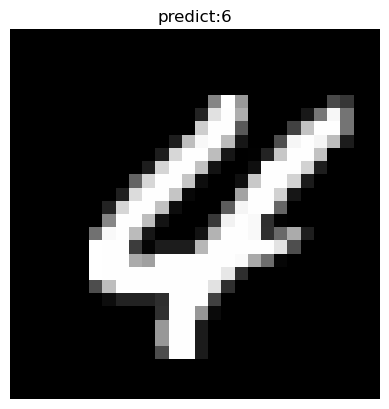

pred: None


Ellipsis

In [128]:
def show_batch_images(model,dataloader,num_image):
    imagens, label = next(iter(test_dl))
    pred = make_prediction(model,imagens[3]) 
    print("pred:",pred)
    return imagens, pred

images, pred = show_batch_images(model,test_dl,1)
...

In [129]:
...

Ellipsis

In [130]:
def get_conv_layers(model):
    conv_layers=list()
    model_children=list(model.children())
    for child in model_children:
        if type(child)==Conv2d:
            conv_layers.append(child)
        elif type(child)==Sequential:   
            for layer in child.children():
                if type(layer)==Conv2d:
                    conv_layers.append(layer)
    ...

def get_conv_pool_layers(model):
    conv_layers=list()
    model_children=list(model.children())
    for child in model_children:
        if type(child)==Conv2d or type(child)==MaxPool2d:
            conv_layers.append(child)
        elif type(child)==Sequential:   
            for layer in child.children():
                if type(layer)==Conv2d or (type(layer)==MaxPool2d):
                    conv_layers.append(layer)
    ...

conv_layers = get_conv_pool_layers(model)
print(conv_layers)
print(len(conv_layers))

None


TypeError: object of type 'NoneType' has no len()

In [ ]:
def percorrer_conv_layers(images, conv_layers):
    images = images.to(device)
    results = [conv_layers[0](images)]
    for i in range(1, len(conv_layers)):
        results.append(conv_layers[i](results[-1]))
    outputs = results
    return outputs

...
print(f"Obtiveram-se {len(outputs)} tensores com o shape:")
for i in range(len(outputs)):
    print(f"    Layer {i} - {outputs[i].shape}")

In [ ]:
def visualize_featureMaps_partial(outputs,num_imagem):
    for num_layer in range(len(outputs)):
        plt.figure(figsize=(14, 7))
        layer_viz = outputs[num_layer][num_imagem, :, :, :]
        layer_viz = layer_viz.data
        print("Layer ",num_layer+1)
        for i, filter in enumerate(layer_viz):
            if i == 18: 
                break
            plt.subplot(3, 6, i + 1)
            plt.imshow(filter.cpu(), cmap='gray')
            plt.axis("off")
        plt.show()
        plt.close()

...